In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
YOUR_API_KEY = 'W1KNO2X49YLY9LTB'

In [2]:
import requests

base_url = 'https://www.alphavantage.co/query?'
params = {'function': 'OVERVIEW',
         'symbol': 'IBM',
         'apikey': YOUR_API_KEY}

response = requests.get(base_url, params=params)

print(response.json())
test = response.json()['Name']
print(test)

{'Symbol': 'IBM', 'AssetType': 'Common Stock', 'Name': 'International Business Machines Corporation', 'Description': "International Business Machines Corporation operates as an integrated solutions and services company worldwide. Its Cloud & Cognitive Software segment offers software for vertical and domain-specific solutions in health, financial services, and Internet of Things (IoT), weather, and security software and services application areas; and customer information control system and storage, and analytics and integration software solutions to support client mission critical on-premise workloads in banking, airline, and retail industries. It also offers middleware and data platform software, including Red Hat, which enables the operation of clients' hybrid multi-cloud environments; and Cloud Paks, WebSphere distributed, and analytics platform software, such as DB2 distributed, information integration, and enterprise content management, as well as IoT, Blockchain and AI/Watson pl

In [3]:
from tqdm import tqdm

def request_stock_price_hist(symbol, token, sample = False):
    if sample == False:
        q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&outputsize=full&apikey={}'
    else:
        q_string = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&apikey={}'

    print("Retrieving stock price data from Alpha Vantage (This may take a while)...")
    r = requests.get(q_string.format(symbol, token))
    print("Data has been successfully downloaded...")
    date = []
    colnames = list(range(0, 7))
    df = pd.DataFrame(columns = colnames)
    print("Sorting the retrieved data into a dataframe...")
    for i in tqdm(r.json()['Time Series (Daily)'].keys()):
        date.append(i)
        row = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'][i], orient='index').reset_index().T[1:]
        df = pd.concat([df, row], ignore_index=True)
    df.columns = ["open", "high", "low", "close", "adjusted close", "volume", "dividend amount", "split cf"]
    df['date'] = date
    return df

In [6]:
df = request_stock_price_hist('IBM', 'REPLACE_YOUR_TOKEN')
# df.to_csv('output.csv')

Retrieving stock price data from Alpha Vantage (This may take a while)...


  0%|          | 6/5299 [00:00<01:31, 58.10it/s]

Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 5299/5299 [01:04<00:00, 50.98it/s]


In [7]:
df.head()

,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
0,116.54,117.45,115.89,117.18,117.18,3439648,0.0000,1.0,2020-11-19
1,117.72,118.88,116.75,116.77,116.77,4606828,0.0000,1.0,2020-11-18
2,117.6,118.54,117.07,117.7,117.7,4134455,0.0000,1.0,2020-11-17
3,118.3,118.55,117.12,118.36,118.36,5293385,0.0000,1.0,2020-11-16
4,115.19,117.37,115.01,116.85,116.85,4683512,0.0000,1.0,2020-11-13


In [8]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [9]:
df['high'] = df['high'].astype(float)

In [10]:
df['low'] = df['low'].astype(float)

/Users/wangmacpro/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/wangmacpro/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


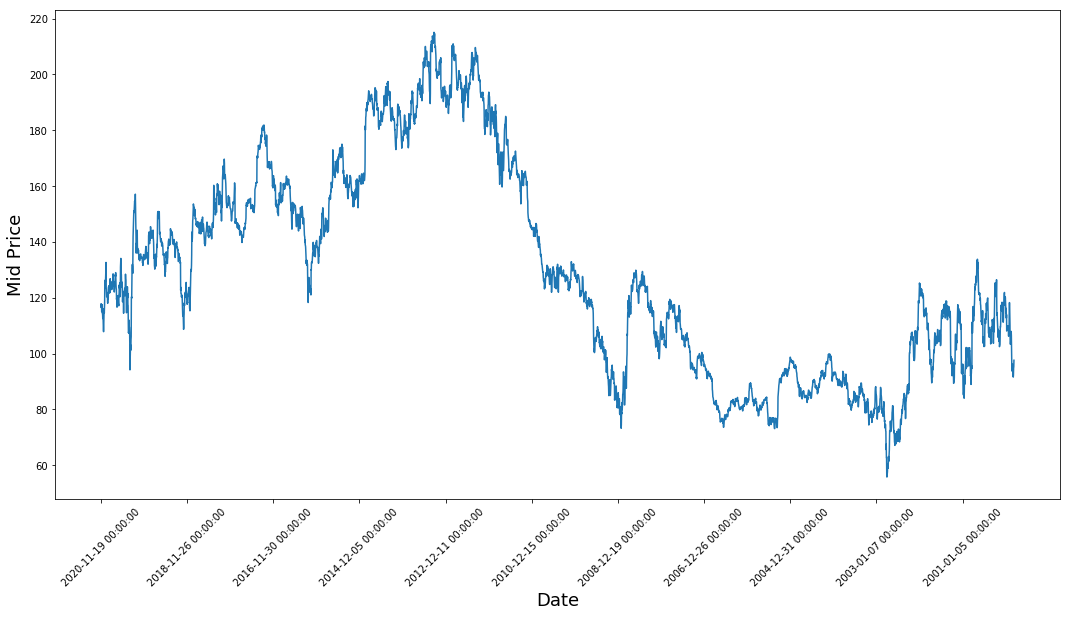

In [11]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

# Publicly Traded Companies

data table acquired from Fintel.io for Publicly Traded Drugs Companies - SIC Code 283

In [12]:
sic_283 = pd.read_csv("SIC_Code_283.csv")

In [13]:
sic_283.head()

,Exchange,Ticker,Country,Name,Market Cap ($M)
0,NASDAQ,ATNF,US,180 Life Sciences Corp.,12
1,OTC,FFNTF,US,4Front Ventures Corp,89
2,NASDAQ,ETNB,US,"89bio, Inc.",520
3,NASDAQ,NMTR,US,"9 Meters Biopharma, Inc.",145
4,NASDAQ,ACIU,US,AC Immune SA,370


In [14]:
sic_283.shape

(1161, 5)

In [15]:
CT_company_name = pd.read_csv("CT_company_name.csv")

In [16]:
CT_company_name.head()


,Unnamed: 0,company_name,count
0,0,GlaxoSmithKline,2667
1,1,Pfizer,2171
2,2,AstraZeneca,1771
3,3,Merck Sharp & Dohme Corp.,1740
4,4,Novartis Pharmaceuticals,1630


In [17]:
print(CT_company_name.shape)

(8488, 3)


In [18]:
del CT_company_name['Unnamed: 0']

In [19]:
 CT_company_name = CT_company_name.rename(columns={'company_name':'Name', 'count':'Trial_count'})

In [20]:
CT_company_name.head()

,Name,Trial_count
0,GlaxoSmithKline,2667
1,Pfizer,2171
2,AstraZeneca,1771
3,Merck Sharp & Dohme Corp.,1740
4,Novartis Pharmaceuticals,1630


In [21]:
 df_new = pd.merge(left=sic_283, right=CT_company_name, left_on='Name', right_on='Name', how='outer')

In [22]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9443 entries, 0 to 9442
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Exchange         1114 non-null   object 
 1   Ticker           1161 non-null   object 
 2   Country          1161 non-null   object 
 3   Name             9443 non-null   object 
 4   Market Cap ($M)  889 non-null    object 
 5   Trial_count      8502 non-null   float64
dtypes: float64(1), object(5)
memory usage: 516.4+ KB


In [25]:
pd.set_option('display.max_rows', 500)

In [31]:
df_new.sort_values(by="Name")

,Exchange,Ticker,Country,Name,Market Cap ($M),Trial_count
6521,NaN,NaN,NaN,"10xBio, LLC",NaN,1.0
7170,NaN,NaN,NaN,11 Heath and Technologies Limited,NaN,1.0
0,NASDAQ,ATNF,US,180 Life Sciences Corp.,12,NaN
5360,NaN,NaN,NaN,1Globe Health Institute LLC,NaN,2.0
4776,NaN,NaN,NaN,1QB Information Technologies Inc.,NaN,2.0
...,...,...,...,...,...,...
5943,NaN,NaN,NaN,usMIMA S.L.,NaN,1.0
2109,NaN,NaN,NaN,vTv Therapeutics,NaN,9.0
1160,NASDAQ,VTVT,US,vTv Therapeutics Inc,140,NaN
8274,NaN,NaN,NaN,Ångstrom Pharmaceuticals,NaN,1.0


In [32]:
df_new.tail(30)

,Exchange,Ticker,Country,Name,Market Cap ($M),Trial_count
9413,NaN,NaN,NaN,Tigran Technologies AB,NaN,1.0
9414,NaN,NaN,NaN,Avena Nordic Grain Oy,NaN,1.0
9415,NaN,NaN,NaN,Ostar Meditech Corp,NaN,1.0
9416,NaN,NaN,NaN,"Avacen, Inc.",NaN,1.0
9417,NaN,NaN,NaN,"SK Telecom Americas, Inc.",NaN,1.0
9418,NaN,NaN,NaN,FutureChem,NaN,1.0
9419,NaN,NaN,NaN,Promefarm S.r.l.,NaN,1.0
9420,NaN,NaN,NaN,"DIApedia, LLC",NaN,1.0
9421,NaN,NaN,NaN,"Anelixis Therapeutics, Inc.",NaN,1.0
9422,NaN,NaN,NaN,Flinders Fertility,NaN,1.0


In [27]:
for ticker in df_new['Ticker'][:5]: # write a function  that takes ticker name from list and calls stock prices and converts data and returns graph
    print(ticker)
    

ATNF
FFNTF
ETNB
NMTR
ACIU


In [33]:
ETNB = request_stock_price_hist('ETNB', 'REPLACE_YOUR_TOKEN')

Retrieving stock price data from Alpha Vantage (This may take a while)...


 17%|█▋        | 43/260 [00:00<00:00, 422.16it/s]

Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 260/260 [00:00<00:00, 466.99it/s]


In [34]:
ETNB

,open,high,low,close,adjusted close,volume,dividend amount,split cf,date
0,25.91,27.0399,25.52,25.97,25.97,110713,0.0000,1.0,2020-11-19
1,26.99,27.295,25.595,26.15,26.15,217864,0.0000,1.0,2020-11-18
2,27.88,28.24,26.4,26.67,26.67,106272,0.0000,1.0,2020-11-17
3,26.92,28.25,26.66,28.08,28.08,257809,0.0000,1.0,2020-11-16
4,25.24,27.23,25.02,26.88,26.88,226335,0.0000,1.0,2020-11-13
5,24.94,25.39,24.22,25.08,25.08,351978,0.0000,1.0,2020-11-12
6,25.72,25.72,24.09,24.79,24.79,282626,0.0000,1.0,2020-11-11
7,25.12,25.23,24.3,24.3,24.3,156823,0.0000,1.0,2020-11-10
8,25.13,25.37,24.66,24.99,24.99,123242,0.0000,1.0,2020-11-09
9,24.75,24.99,24.4201,24.68,24.68,65308,0.0000,1.0,2020-11-06


/Users/wangmacpro/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/wangmacpro/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


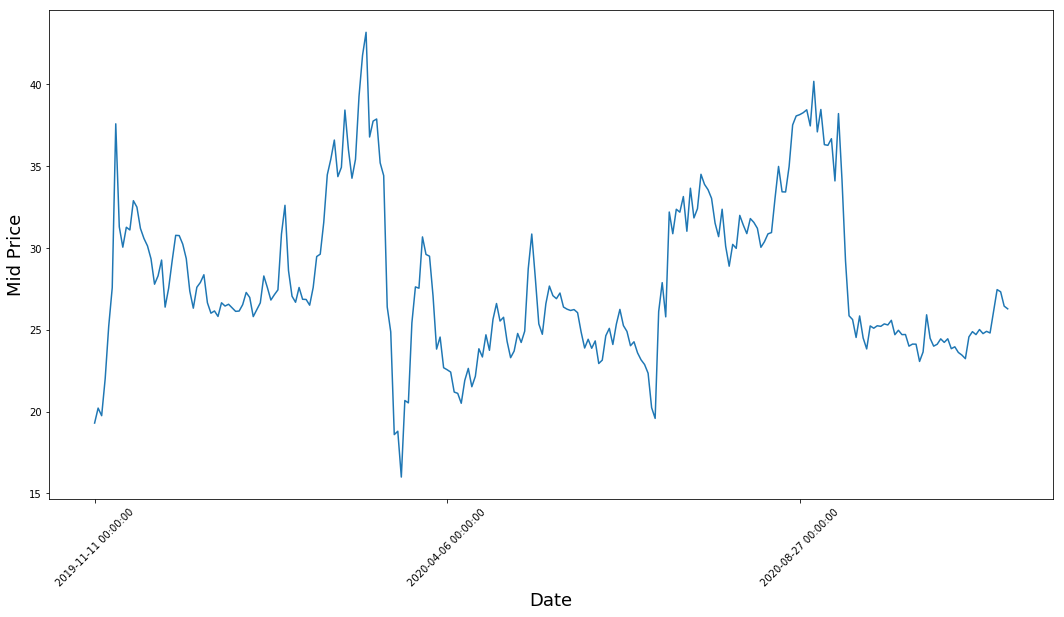

In [35]:
ETNB['date'] = pd.to_datetime(ETNB['date'], format='%Y-%m-%d')
ETNB.sort_values(by="date", ascending=True, inplace=True)
ETNB['high'] = ETNB['high'].astype(float)
ETNB['low'] = ETNB['low'].astype(float)
plt.figure(figsize = (18,9))
plt.plot(range(ETNB.shape[0]),(ETNB['low']+ETNB['high'])/2.0)
plt.xticks(range(0,ETNB.shape[0],100),ETNB['date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [36]:
df_new[df_new['Ticker'] == 'ETNB']

,Exchange,Ticker,Country,Name,Market Cap ($M),Trial_count
2,NASDAQ,ETNB,US,"89bio, Inc.",520,1.0


In [37]:
GCVRZ_sanafi = request_stock_price_hist('GCVRZ', YOUR_API_KEY)

Retrieving stock price data from Alpha Vantage (This may take a while)...


  1%|          | 16/2246 [00:00<00:14, 158.21it/s]

Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 2246/2246 [00:14<00:00, 156.26it/s]


/Users/wangmacpro/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/wangmacpro/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


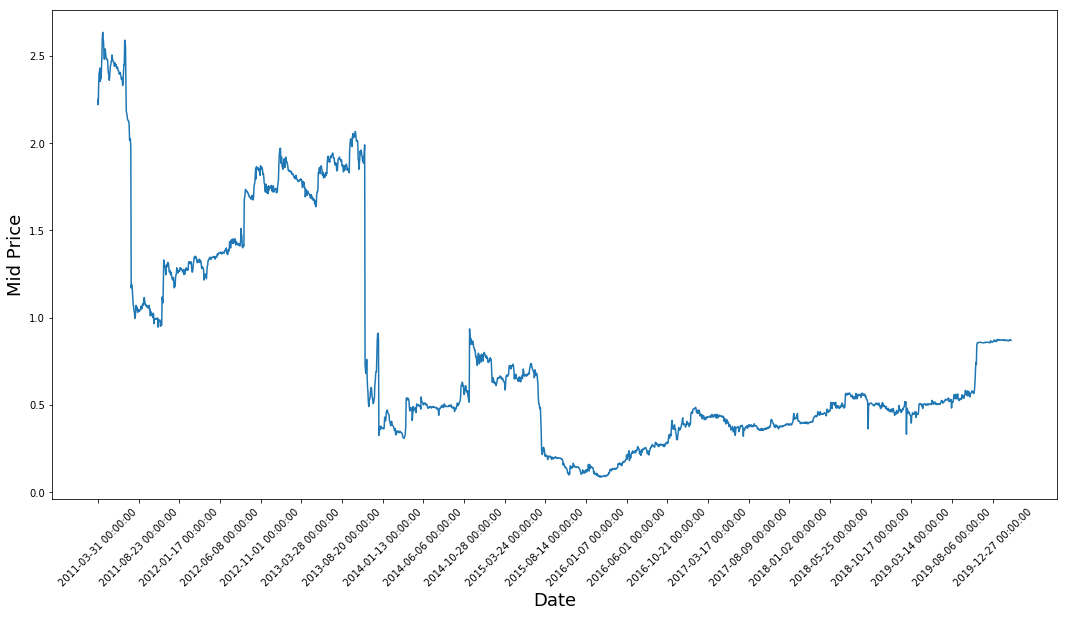

In [38]:
GCVRZ_sanafi['date'] = pd.to_datetime(GCVRZ_sanafi['date'], format='%Y-%m-%d')
GCVRZ_sanafi.sort_values(by="date", ascending=True, inplace=True)
GCVRZ_sanafi['high'] = GCVRZ_sanafi['high'].astype(float)
GCVRZ_sanafi['low'] = GCVRZ_sanafi['low'].astype(float)
plt.figure(figsize = (18,9))
plt.plot(range(GCVRZ_sanafi.shape[0]),(GCVRZ_sanafi['low']+GCVRZ_sanafi['high'])/2.0)
plt.xticks(range(0,GCVRZ_sanafi.shape[0],100),GCVRZ_sanafi['date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [39]:
SNY = request_stock_price_hist('SNY', YOUR_API_KEY)

Retrieving stock price data from Alpha Vantage (This may take a while)...


  0%|          | 8/4632 [00:00<01:01, 75.20it/s]

Data has been successfully downloaded...
Sorting the retrieved data into a dataframe...


100%|██████████| 4632/4632 [00:57<00:00, 91.79it/s] 


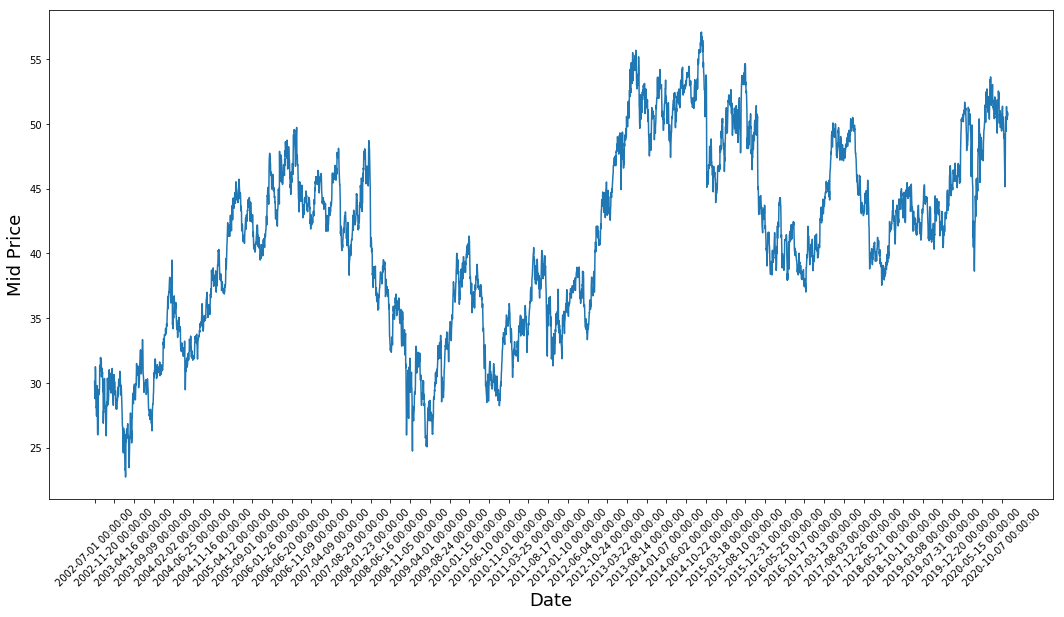

In [40]:
SNY['date'] = pd.to_datetime(SNY['date'], format='%Y-%m-%d')
SNY.sort_values(by="date", ascending=True, inplace=True)
SNY['high'] = SNY['high'].astype(float)
SNY['low'] = SNY['low'].astype(float)
plt.figure(figsize = (18,9))
plt.plot(range(SNY.shape[0]),(SNY['low']+SNY['high'])/2.0)
plt.xticks(range(0,SNY.shape[0],100),SNY['date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()